# 批量规范化

:label:`sec_batch_norm`

训练深层神经网络是十分困难的，特别是在较短的时间内使他们收敛更加棘手。
本节将介绍*批量规范化*（batch normalization） :cite:`Ioffe.Szegedy.2015`，这是一种流行且有效的技术，可持续加速深层网络的收敛速度。
再结合在 :numref:`sec_resnet`中将介绍的残差块，批量规范化使得研究人员能够训练100层以上的网络。

## (**从零实现**)

下面，我们从头开始实现一个具有张量的批量规范化层。

In [2]:
import torch
from torch import nn

import sys
sys.path.append("..")
import d2lzh_pytorch.torch as d2l
from d2lzh_pytorch.CNN.LeNet_mode import get_LeNet_mode



In [3]:

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
        pass

    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean.data, moving_var.data


我们现在可以[**创建一个正确的`BatchNorm`层**]。
这个层将保持适当的参数：拉伸`gamma`和偏移`beta`,这两个参数将在训练过程中更新。
此外，我们的层将保存均值和方差的移动平均值，以便在模型预测期间随后使用。

撇开算法细节，注意我们实现层的基础设计模式。
通常情况下，我们用一个单独的函数定义其数学原理，比如说`batch_norm`。
然后，我们将此功能集成到一个自定义层中，其代码主要处理数据移动到训练设备（如GPU）、分配和初始化任何必需的变量、跟踪移动平均线（此处为均值和方差）等问题。
为了方便起见，我们并不担心在这里自动推断输入形状，因此我们需要指定整个特征的数量。
不用担心，深度学习框架中的批量规范化API将为我们解决上述问题，我们稍后将展示这一点。


In [4]:
class BatchNorm(nn.Module):
    
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
            
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
            
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y


##  使用批量规范化层的 LeNet

为了更好理解如何[**应用`BatchNorm`**]，下面我们将其应用(**于LeNet模型**)（ :numref:`sec_lenet`）。
回想一下，批量规范化是在卷积层或全连接层之后、相应的激活函数之前应用的。


In [5]:

# 获取 LetNet模型
# net = get_LeNet_mode()


net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),  # 加入 BatchNorm
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),   # 加入 BatchNorm
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

和以前一样，我们将[**在Fashion-MNIST数据集上训练网络**]。
这个代码与我们第一次训练LeNet（ :numref:`sec_lenet`）时几乎完全相同，主要区别在于学习率大得多。


In [5]:
lr = 0.1
num_epochs = 10
batch_size = 128

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

loss 0.302, train acc 0.892, test acc 0.866
59172.8 examples/sec on cuda:0


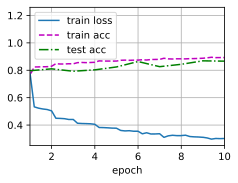

In [6]:
# 训练
d2l.train_ch6(net, train_iter, test_iter, 
              num_epochs, 
              lr, 
              d2l.try_gpu()
             )

让我们来看看从第一个批量规范化层中学到的[**拉伸参数`gamma`和偏移参数`beta`**]。


In [7]:
net[1].gamma.reshape((-1,))

tensor([1.6976, 1.6783, 2.0053, 1.8482, 1.7727, 1.7501], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)

In [8]:
net[1].beta.reshape((-1,))

tensor([ 1.0940, -0.4740,  1.5870, -0.4537,  1.3062,  1.3878], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)

## 小结

* 在模型训练过程中，批量规范化利用小批量的均值和标准差，不断调整神经网络的中间输出，使整个神经网络各层的中间输出值更加稳定。
* 批量规范化在全连接层和卷积层的使用略有不同。
* 批量规范化层和暂退层一样，在训练模式和预测模式下计算不同。
* 批量规范化有许多有益的副作用，主要是正则化。另一方面，”减少内部协变量偏移“的原始动机似乎不是一个有效的解释。